#Training model1_suit

In [1]:
import numpy as np
import cv2
import sys
import random
import glob
import re
import time
import os
from tqdm.notebook import tqdm as log_progress
from matplotlib import pyplot as plt

from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

###Complete this basing on where you are running the notebook:

In [2]:
on_colab = True
EPOCHS = 55
LEN_TRAINING_DATA = 75000
if on_colab:
    !git clone https://github.com/andreorto98/scopa.git:
    path_to_deck = './scopa/scopa/new_deck/'
if not on_colab:
    path_to_deck = './new_deck/'

Cloning into 'on_colab:'...
fatal: could not read Username for 'https://github.com': No such device or address


In [3]:
def transform_img(img, angle = 0, scale = 1, tr = (0,0)):
  input_img_shape = img.shape
  img_center = (int(input_img_shape[0]/2), int(input_img_shape[1]/2))
  trasl_mat = np.zeros((2,3))
  trasl_mat[0,2]=tr[0]
  trasl_mat[1,2]=tr[1]
  trasl_mat[0,0] = trasl_mat[1][1] = 1
  img = cv2.warpAffine(img, trasl_mat, img.shape[0:2], flags=cv2.INTER_LINEAR)
  rot_mat = cv2.getRotationMatrix2D(img_center, angle, scale)
  img = cv2.warpAffine(img, rot_mat, img.shape[0:2], flags=cv2.INTER_LINEAR)
  return img.reshape(input_img_shape)


def generate_cards(n=1, layers=3, ang = True, traslate=False):
    cards = np.random.randint(1,41,n, np.uint8)
    if ang:
        angles= np.random.uniform(0,360,n)
    else:
        angles = np.full(n, 0.)
    scales= np.random.uniform(0.9,1.1,n)
    if layers == 1:
        print(path_to_deck+"*.jpg")
        inp_images = sorted([file for file in glob.glob(path_to_deck+"*.jpg")], key = string_to_n_card)
        inp_images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE).reshape(256,256,1) for file in inp_images]
    elif layers == 3:
        inp_images = sorted([file for file in glob.glob("./deck0/*.jpg")], key = string_to_n_card)
        inp_images = [cv2.imread(file)[232:488,232:488] for file in inp_images]
    image_shape = inp_images[0].shape

    if traslate:
        marg = 5
        max_tr_x = int(image_shape[0]/2-image_shape[0]/marg)
        max_tr_y = int(image_shape[1]/2-image_shape[1]/marg)
        tr_x = np.random.randint(0,max_tr_x,n)
        tr_y = np.random.randint(0,max_tr_y,n)
    else:
        tr_x = np.zeros(n)
        tr_y = np.zeros(n)

    images = [transform_img(inp_images[cards[i]-1], angles[i], scales[i], (tr_x[i], tr_y[i]))
              for i in log_progress(range(len(cards)))]

    return np.array(images), np.array(cards)

def string_to_n_card(str):
    if str.startswith('.'):
         words = re.split('_|/|.j', str)[-3:-1]
    else: words = str.split('_')
    suit_to_n = {'hearts':0, 'diamonds':10, 'clubs':20, 'spades':30}
    return int(words[0])+suit_to_n[words[1]]

In [5]:
n_samples = LEN_TRAINING_DATA

print('start time1')
start = time.time()

# Generate training data1
train_data, target = generate_cards(n_samples, 1, True)

print(train_data.shape, target.shape)

print('cards_generated')
print("--- %s seconds ---" % (time.time() - start))

start time1
./scopa/scopa/new_deck/*.jpg



(75000, 256, 256, 1) (75000,)
cards_generated
--- 84.575355052948 seconds ---


In [6]:
print(f'Dimension of train_data (MB): {sys.getsizeof(train_data)/1e6:.0f}', train_data.shape)


'''     MODEL1:
        Each image contains one card.
        The card is recognised looking separately to the suit and to the carder

        lo metteremo dentro una funzione train_model1()
'''

def card_to_suit(card):
    if card<11:
        return [1.,0.,0.,0.]
    elif card<21:
        return [0.,1.,0.,0.]
    elif card<31:
        return [0.,0.,1.,0.]
    else:
        return [0.,0.,0.,1.]


model1 = True
if model1:
    # creating the ground truth labels
    labels = np.array([card_to_suit(card) for card in target])

    # building the model: suit
    inputs = Input(shape=train_data[0].shape)
    conv = Conv2D(3, (2,2), activation = 'relu', input_shape=train_data[0].shape)(inputs)
    pool = MaxPooling2D(pool_size=(2,2))(conv)
    conv = Conv2D(3, (2,2), activation = 'relu')(pool)
    pool = MaxPooling2D(pool_size=(2,2))(conv)
    conv = Conv2D(2, (2,2), activation = 'relu')(pool)
    pool = MaxPooling2D(pool_size=(3,3))(conv)

    flatten = Flatten()(pool)
    dense = Dense(32, activation='relu')(flatten)
    outputs = Dense(4,activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['categorical_accuracy'])

    model.summary()
    history = model.fit(train_data, labels, validation_split=0.8, epochs= EPOCHS, verbose=1)
    
    print('end of training')
    print("--- %s seconds ---" % (time.time() - start))



Dimension of train_data (MB): 4915 (75000, 256, 256, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 255, 255, 3)       15        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 3)       39        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 2)         26        
_________________________________________________________________
max_p

./scopa/scopa/new_deck/*.jpg



Accuracy test set:	96.1%
val_categorical_accuracy
[0.613556444644928, 0.8189696669578552, 0.8822519779205322, 0.9063015580177307, 0.9232679605484009, 0.9254845976829529, 0.9291344881057739, 0.9349844455718994, 0.9329344630241394, 0.9274178743362427, 0.9318511486053467, 0.9425342679023743, 0.9416009783744812, 0.9408509731292725, 0.9419842958450317, 0.9423342943191528, 0.9366177320480347, 0.9465342164039612, 0.9444342851638794, 0.9397010207176208, 0.9426009654998779, 0.9470175504684448, 0.9480008482933044, 0.9521341323852539, 0.945584237575531, 0.9444175958633423, 0.9477675557136536, 0.9504841566085815, 0.9483675360679626, 0.9498008489608765, 0.9486508369445801, 0.9527508020401001, 0.9519007802009583, 0.9485341906547546, 0.9513508081436157, 0.9493841528892517, 0.9518008232116699, 0.9526007771492004, 0.9513841271400452, 0.9412176609039307, 0.9570507407188416, 0.9508841633796692, 0.9549174308776855, 0.9500341415405273, 0.9537507891654968, 0.9523007869720459, 0.9525008201599121, 0.95521742

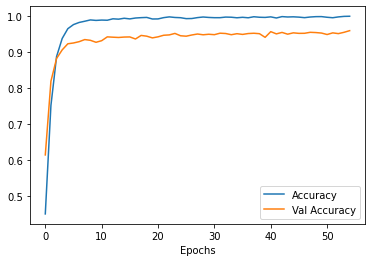

----------------------------------------------


In [9]:
test_data, target = generate_cards(int(n_samples/10), 1, True)

test_pred = model.predict(test_data)
test_pred = np.array([np.argmax(test_pred[i]) for i in range(len(test_pred))])
test_label = np.array([card_to_suit(card) for card in target])
test_label = np.array([np.argmax(test_label[i]) for i in range(len(test_label))])

from sklearn import metrics

print(f'Accuracy test set:\t{metrics.accuracy_score(test_label, test_pred):.1%}')
print('val_categorical_accuracy')
print(history.history["val_categorical_accuracy"])
print('categorical_accuracy')
print(history.history["categorical_accuracy"])


plt.plot(history.history["categorical_accuracy"], label='Accuracy')
plt.plot(history.history["val_categorical_accuracy"], label='Val Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

print('----------------------------------------------')

In [10]:
save = True
if save:
  if on_colab:
    model.save('./scopa/scopa/new_models/suit_model.h5') 
  else:
    model.save('./new_models/suit_model.h5')